<a href="https://colab.research.google.com/github/jcmachicao/gdmk_uc__reportes_edusights/blob/main/edusights_deep_captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
from modelos.model_packer import ImprovedNN

In [ ]:
VERSION_NAME = 'S2_CON_69'
INI_IDX, END_IDX = 5000, 8000

In [ ]:
folder_path = 'archivos/'
os.listdir(folder_path)

['df_Ingresantes_uvir_2220al2410_deserción.pkl',
 'drive-download-20240728T214819Z-001.zip',
 'Estudiantes_202420_al1107.xlsx',
 'lista_categorias_testing.xlsx',
 'X_test.pt',
 'X_train.pt',
 'y_test.pt',
 'y_train.pt']

In [ ]:
base_df = pd.read_excel(folder_path+'lista_categorias_testing.xlsx')
base_df.columns

Index(['Unnamed: 0', 0], dtype='object')

In [ ]:
columnas_list = list(base_df[0])

In [ ]:
sample_df = pd.read_pickle(folder_path+'df_Ingresantes_uvir_2220al2410_deserción.pkl').dropna()
sample_df.columns

Index(['Tiempo_espera', 'DNI', 'NOMBRE', 'TIPO_INGRESANTE',
       'ESTADO_INGRESANTE', 'APROBO_RV', 'APROBO_RM', 'Puntaje_Admisión',
       'Edad', 'Rango_Edad', 'Sexo', 'Dep_viv_act', 'Dis_viv_act', 'Migrante',
       'Estado Civil', 'Dependientes', 'Vives_con', 'Tipo_de_cole',
       'Max_Grado', 'Estudio_Madre', 'Estudio_Padre', 'Tipo_lugar_origen',
       'Ocupación', 'Tipo_trabajo', 'Ingre_estudiante', 'Ingre_familia',
       'Dispo_Internet'],
      dtype='object')

In [ ]:
dni_list = list(sample_df.DNI)
print(len(dni_list))
dni_list_selec = dni_list[INI_IDX:END_IDX]
len(dni_list_selec)

8020


3000

In [ ]:
folder_path = 'C://Users/PC}/Documents/2024_Q5/edusights_prediccion_sample/modelos/'
os.listdir(folder_path)

['edusights_20240702_model_CON_50.pth',
 'edusights_20240702_model_S2_CON_69.pth',
 'edusights_20240702_state_dict_CON_50.pth',
 'edusights_20240702_state_dict_S2_CON_69.pth',
 'model_improvednn_S2_CON_69.pkl',
 'model_packer.py']

In [ ]:
input_size = 149
num_classes = 2
DROPOUTX = 0.1
model = ImprovedNN(input_size)

In [ ]:
model_dict_path = f'modelos/edusights_20240702_state_dict_{VERSION_NAME}.pth'
state_dict = torch.load(model_dict_path, map_location=torch.device('cpu'))
model.eval()

ImprovedNN(
  (fc1): Linear(in_features=149, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

In [ ]:
folder_path = 'C://Users/PC}/Documents/2024_Q5/edusights_prediccion_sample/archivos/'
sample_file = 'Estudiantes_202420_al1107.xlsx'
X_test_file = 'X_train_tensor_sample.pt'
X_test_file = 'X_train_tensor.pt'

In [ ]:
X_sample_tensor = torch.load(folder_path + X_test_file)
X_sample_tensor.shape

torch.Size([8020, 149])

In [ ]:
X_sample_tensor_B = X_sample_tensor[INI_IDX:END_IDX, :]
X_sample_tensor_B.shape

torch.Size([3000, 149])

In [ ]:
!pip install captum

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 1.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.3 MB 1.7 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.3 MB 2.9 MB/s eta 0:00:01
   -------------------- ------------------- 0.7/1.3 MB 4.4 MB/s eta 0:00:01
   ----------------------------- ---------- 1.0/1.3 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 5.0 MB/s eta 0:00:00


In [ ]:
from captum.attr import IntegratedGradients, Saliency, DeepLift

In [ ]:
input_tensor = X_sample_tensor_B
ig = IntegratedGradients(model)

In [ ]:
target_class = 0  # Specify the target class if needed
attributions, delta = ig.attribute(input_tensor, target=target_class, return_convergence_delta=True)

In [ ]:
# Convert attributions to DataFrame
REDUC_COLS, REDUC_ROWS = 0.70, 0.990
pos_not = [147, 148]
attributions_array = attributions.squeeze().cpu().detach().numpy()
df = pd.DataFrame(attributions_array)
column_mean_abs = df.abs().mean(axis=0)
row_mean_abs = df.abs().mean(axis=1)
threshold_col = column_mean_abs.quantile(REDUC_COLS)
threshold_row = row_mean_abs.quantile(REDUC_ROWS)
cols_to_keep = column_mean_abs[column_mean_abs > threshold_col].index
rows_to_keep = row_mean_abs[row_mean_abs > threshold_row].index
print(list(cols_to_keep))
print(list(rows_to_keep))
reduced_df = df.loc[rows_to_keep, cols_to_keep[:-2]]

[1, 4, 6, 7, 9, 12, 14, 18, 19, 38, 58, 59, 61, 64, 66, 67, 70, 71, 73, 76, 78, 79, 81, 88, 89, 99, 104, 115, 116, 119, 121, 127, 129, 130, 131, 132, 133, 136, 138, 139, 141, 143, 146, 147, 148]
[20, 318, 322, 350, 385, 468, 567, 669, 1399, 1418, 1422, 1437, 1481, 1483, 1489, 1490, 1533, 1534, 1622, 1624, 1773, 1848, 2164, 2213, 2312, 2400, 2525, 2679, 2689, 2828]


In [ ]:
lcol = list(cols_to_keep)
lcolfit = lcol[:-2]

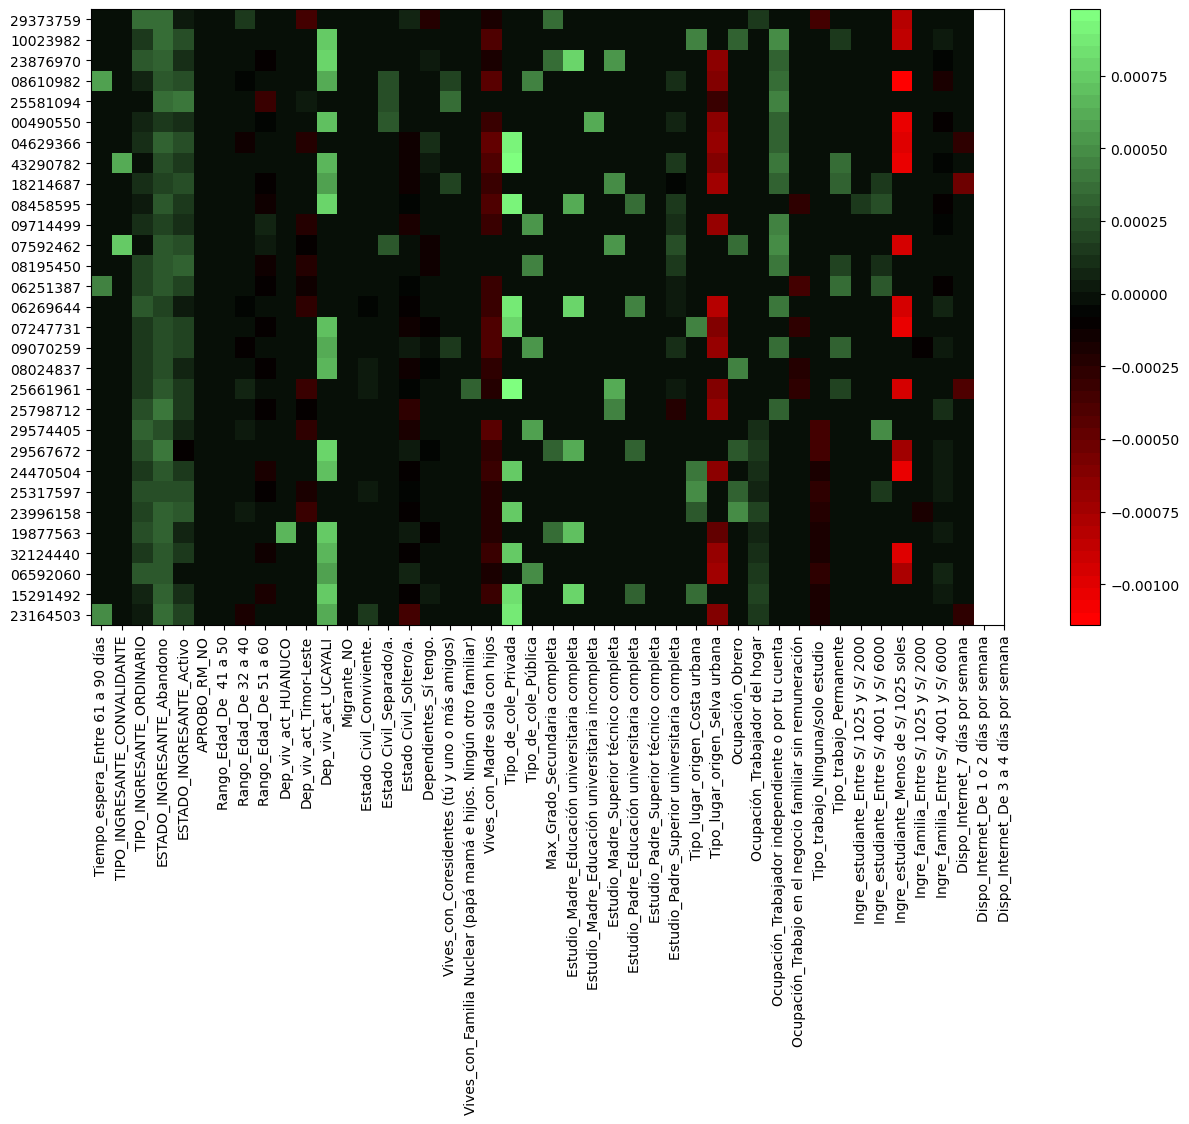

In [ ]:
fig = plt.figure(figsize=(21,8))
colors = [(1, 0, 0), (0, 0, 0), (0.5, 1, 0.5)]  # Red, Black, Light Green
n_bins = 50  # Discretizes the interpolation into bins
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
xtick_labels = [columnas_list[pos] for pos in cols_to_keep]
ytick_labels = [dni_list_selec[pos] for pos in rows_to_keep]
plt.imshow(reduced_df.values, cmap=cm)
plt.xticks(np.arange(len(xtick_labels)), labels=xtick_labels, rotation=90)
plt.yticks(np.arange(len(ytick_labels)), labels=ytick_labels)
plt.colorbar(fraction=0.03, pad=0.04)
plt.show()

In [ ]:
fig.savefig('D://resultado_base_20240728.png')